#Step 3
Added Batch normalization to boost accuracy.

#Results:
*   Parameters: 10.1k
*   Best Train Accuracy: 99.81
*   Best Test Accuracy: 99.29


#Analysis
*   Adding Batch Normalization in each layer except the last layer, increased our parameters by a less amount, but both train and test accuracy improved a lot.
*   But the model still shows overfitting. Next we try to reduce the gap between train and test accuracy with an aim to keep test accuracy more.

#Journey of the model
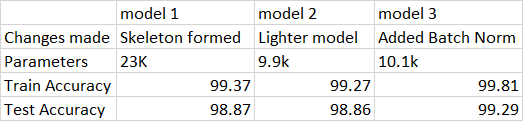

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/ML_assignment/ERA_V1/S7/ToSubmit/"

Mounted at /content/drive
/content/drive/MyDrive/ML_assignment/ERA_V1/S7/ToSubmit


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from model import train_model, test_model
from utils import plot_data, plot_loss_accuracy

In [ ]:
# Device configuration -use CUDA tensor types if available
cuda = torch.cuda.is_available()
device = 'cuda' if cuda else 'cpu'
print("CUDA Available?", cuda)
SEED = 1
# For reproducibility
torch.manual_seed(SEED)

if cuda:
  torch.cuda.manual_seed(SEED)

CUDA Available? False


In [ ]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.ToTensor(),   #convert image to PyTorch tensor
    transforms.Normalize((0.1307,), (0.3081,)), #normalize test with  mean=0.1307 & standard deviation 0.3081
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) #apply the same normalization of train set to test set
    ])

In [ ]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms) #loads train-images-idx3-ubyte: training set images
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)  #loads t10k-images-idx3-ubyte

In [ ]:
batch_size = 128

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

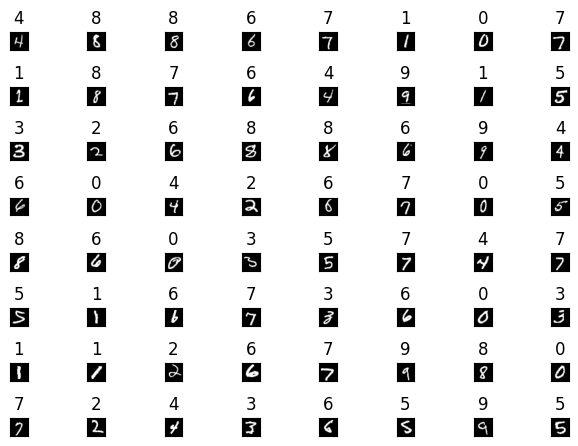

In [ ]:
import matplotlib.pyplot as plt
batch_data, batch_label = next(iter(train_loader))
# batch_data, batch_label = next(iter(test_loader))
plot_data(batch_data, batch_label, 64, 8, 8)

In [ ]:
#This class contains the architecture of the neural network
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(1, 8, 3, bias=False, padding=1), #Image Input: 28x28x1 -> 28x28x16  #Receptive Field 1 -> 3
        nn.ReLU(),
        nn.BatchNorm2d(8),
        nn.Conv2d(8, 16, 3, bias=False), #Input: 28x28x16 -> 26x26x32  #Receptive Field 3 -> 5
        nn.ReLU(),
        nn.BatchNorm2d(16),
        #Transition Block = MaxPool + 1x1 Convolution
        #nn.Conv2d(16, 8, 1, bias=False),
        nn.MaxPool2d(2, 2),    #Input: 13x13x32 -> 13x13x32  #Receptive Field  5 -> 6
        nn.Conv2d(16, 8, 1, bias=False)   #Input: 13x13x32 -> 13x13x16  #Receptive Field  6 -> 6
    )

    self.conv2 = nn.Sequential(
        nn.Conv2d(8, 8, 3, bias=False),  #Input: 13x13x16 -> 11x11x16  #Receptive Field  6 -> 10
        nn.ReLU(),
        nn.BatchNorm2d(8),
        nn.Conv2d(8, 8, 3, bias=False),  #Input: 11x11x16 -> 9x9x32  #Receptive Field  10 -> 14
        nn.ReLU(),
        nn.BatchNorm2d(8)
    )
    self.conv3 = nn.Sequential(
        nn.Conv2d(8, 16, 3, bias=False),  #Input: 9x9x32 -> 7x7x16  #Receptive Field  14 -> 18
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Conv2d(16, 16, 3, bias=False),  #Input: 7x7x16 -> 5x5x16  #Receptive Field  18 -> 22
        nn.ReLU(),
        nn.BatchNorm2d(16)
    )
    self.conv4 = nn.Sequential(
        nn.Conv2d(16, 10, kernel_size=(5, 5), bias=False) #Input: 5x5x16 -> 1x1x10  #Receptive Field  22 -> 30
        )

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = x.view(-1, 10)
    x = F.log_softmax(x, dim=1)
    return x

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
              ReLU-2            [-1, 8, 28, 28]               0
       BatchNorm2d-3            [-1, 8, 28, 28]              16
            Conv2d-4           [-1, 16, 26, 26]           1,152
              ReLU-5           [-1, 16, 26, 26]               0
       BatchNorm2d-6           [-1, 16, 26, 26]              32
         MaxPool2d-7           [-1, 16, 13, 13]               0
            Conv2d-8            [-1, 8, 13, 13]             128
            Conv2d-9            [-1, 8, 11, 11]             576
             ReLU-10            [-1, 8, 11, 11]               0
      BatchNorm2d-11            [-1, 8, 11, 11]              16
           Conv2d-12              [-1, 8, 9, 9]             576
    

In [ ]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1, verbose=True)
#Negative log likelihood loss function is used to classify 10 classes [0-9 digits]
criterion = nn.NLLLoss()
num_epochs = 15

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train_acc, train_loss = train_model(model, device, train_loader, optimizer, criterion)
  train_accuracy.append(train_acc)
  train_losses.append(train_loss)
  test_acc, test_loss = test_model(model, device, test_loader, criterion)
  test_accuracy.append(test_acc)
  test_losses.append(test_loss)
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=0.0429 Batch_id=468 Accuracy=95.03: 100%|██████████| 469/469 [00:52<00:00,  8.95it/s]


Test set: Average loss: 0.0005, Accuracy: 9820/10000 (98.20%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.0083 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:50<00:00,  9.22it/s]


Test set: Average loss: 0.0003, Accuracy: 9874/10000 (98.74%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.0216 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:47<00:00,  9.82it/s]


Test set: Average loss: 0.0003, Accuracy: 9886/10000 (98.86%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.0399 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:49<00:00,  9.54it/s]


Test set: Average loss: 0.0003, Accuracy: 9885/10000 (98.85%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.0236 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:47<00:00,  9.84it/s]


Test set: Average loss: 0.0002, Accuracy: 9900/10000 (99.00%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 6


Train: Loss=0.0264 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:49<00:00,  9.50it/s]


Test set: Average loss: 0.0002, Accuracy: 9903/10000 (99.03%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 7


Train: Loss=0.0182 Batch_id=468 Accuracy=99.59: 100%|██████████| 469/469 [00:50<00:00,  9.33it/s]


Test set: Average loss: 0.0002, Accuracy: 9917/10000 (99.17%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 8


Train: Loss=0.0285 Batch_id=468 Accuracy=99.66: 100%|██████████| 469/469 [00:49<00:00,  9.52it/s]


Test set: Average loss: 0.0002, Accuracy: 9923/10000 (99.23%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 9


Train: Loss=0.0022 Batch_id=468 Accuracy=99.72: 100%|██████████| 469/469 [00:48<00:00,  9.76it/s]


Test set: Average loss: 0.0002, Accuracy: 9926/10000 (99.26%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 10


Train: Loss=0.0492 Batch_id=468 Accuracy=99.74: 100%|██████████| 469/469 [00:49<00:00,  9.38it/s]


Test set: Average loss: 0.0002, Accuracy: 9923/10000 (99.23%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 11


Train: Loss=0.0098 Batch_id=468 Accuracy=99.74: 100%|██████████| 469/469 [00:48<00:00,  9.72it/s]


Test set: Average loss: 0.0002, Accuracy: 9929/10000 (99.29%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 12


Train: Loss=0.0168 Batch_id=468 Accuracy=99.76: 100%|██████████| 469/469 [00:51<00:00,  9.15it/s]


Test set: Average loss: 0.0002, Accuracy: 9927/10000 (99.27%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 13


Train: Loss=0.0148 Batch_id=468 Accuracy=99.79: 100%|██████████| 469/469 [00:47<00:00,  9.81it/s]


Test set: Average loss: 0.0002, Accuracy: 9926/10000 (99.26%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 14


Train: Loss=0.0048 Batch_id=468 Accuracy=99.79: 100%|██████████| 469/469 [00:48<00:00,  9.59it/s]


Test set: Average loss: 0.0002, Accuracy: 9927/10000 (99.27%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 15


Train: Loss=0.0008 Batch_id=468 Accuracy=99.81: 100%|██████████| 469/469 [00:48<00:00,  9.71it/s]


Test set: Average loss: 0.0002, Accuracy: 9929/10000 (99.29%)

Adjusting learning rate of group 0 to 1.0000e-04.


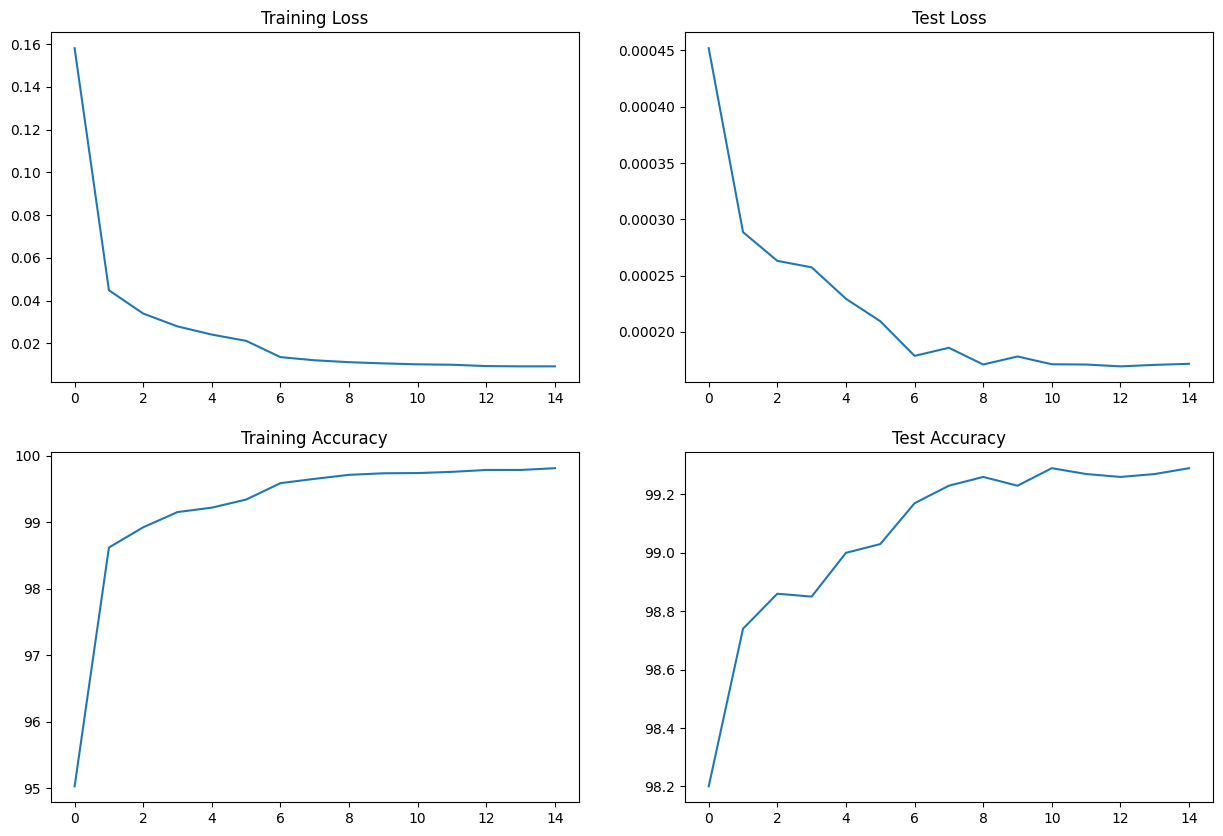

In [ ]:
plot_loss_accuracy(train_losses, test_losses, train_accuracy, test_accuracy)